In [1]:
%matplotlib inline

In [118]:
import time
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split, KFold, cross_val_predict
from sklearn.base import clone
from sklearn.metrics import log_loss
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.grid_search import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from scipy.stats import expon as sp_expon
import matplotlib.pyplot as plt

# Turns off annoying warnings. If there are ever serious data
# errors, trying removing this line.
pd.options.mode.chained_assignment = None

In [3]:
def make_Kaggle_file(predict_probabilities, columns, output_file_name="auto", decimal_limit=3):
    """
    Outputs a file that can be submitted to Kaggle. This takes a long time to run, so you 
    shouldn't run it that often. Instead, just have good internal validation techniques so you
    don't have to check the public leaderboard.
    
    Required imports: 
    import time
    import pandas as pd
    
    predict_probabilities: array-like of shape = [n_samples, n_classes]. Is the output of a 
        predict_proba method of a sklearn classifier
        
    columns: array or list of column names that are in the same order as the columns of the 
        predict_probabilities method. If LabelEncoder was used, is accessed via the classes_ 
        attribute. Don't include an "Id" column.
        
    output_file_name: If "auto" names it sf_crime_test_predictions_<YearMonthDay-HourMinuteSecond>, 
        else uses the string entered as the file name.
        
    decimal_limit: If None uses full precision, else formats predictions based on that precision. 
        Can significantly reduce the filesize and make writing the file faster.
        i.e. actual prediction = .2352452435, decimal_limit=2 --> .24, decimal_limit=3 --> .235, etc.
    """
    predictions = pd.DataFrame(predict_probabilities, columns=columns)
    predictions.index.name = "Id"
    if output_file_name == "auto":
        timestr = time.strftime("%Y%m%d-%H%M%S")
        output_file_name = "sf_crime_test_predictions_" + timestr + ".csv"
    if decimal_limit:
        decimal_limit = '%%.%df' % decimal_limit
    predictions.to_csv(output_file_name, float_format=decimal_limit)
    print("Finished writing file: ", output_file_name)
    
def gridsearch_parameter_results(gridsearch):
    """
    Evaluate how each feature impacts the final prediction.
    """
    scores = [val[1] for val in gridsearch.grid_scores_]
    params = gridsearch.param_distributions.keys()
    for param in params:
        arg_values = [val[0][param] for val in gridsearch.grid_scores_]
        no_strings = all([type(arg) != str for arg in arg_values])
        if no_strings:
            plt.scatter(arg_values, scores, linewidth=0, s=100, alpha=.25)
            plt.title(param)
            plt.show()
        else:
            # Make all arg values strings
            arg_values = [str(arg) for arg in arg_values]
            results = pd.Series(data=scores, index=arg_values)
            group_means = results.groupby(level=0).mean()
            group_means.plot(kind="bar", title=param, rot=0, linewidth=0, colormap="viridis")
            plt.show()

In [467]:
from sklearn.base import TransformerMixin, BaseEstimator

class BasicFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, date_features=True, DayOfWeek_features=True, PdDistrict_features=True, Address_features=True):
        self.date_features = date_features
        self.DayOfWeek_features = DayOfWeek_features
        self.PdDistrict_features = PdDistrict_features
        self.Address_features = Address_features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X_df, y=None):
        # Features from dates
        X = X_df.copy()
        
        if self.date_features:
            X['Year'] = X.Dates.apply(lambda x: int(x[:4])) # Hypothesis: The distribution of crimes changed over time
            X['Month'] = X.Dates.apply(lambda x: int(x[5:7])) # H: Certain crimes occur during some months more than others
            X['Hour'] = X.Dates.apply(lambda x: int(x[11:13])) # H: Certain crimes occur at day, others at night
            X['Minute'] = X.Dates.apply(lambda x: int(x[14:16])) # H: Certain crimes are rounded to the nearest hour
            # Idea: Is holiday feature. H: Holidays --> Tourists --> Different types of crimes

        # Features from DayOfWeek
        if self.DayOfWeek_features:
            X['DayOfWeekNum'] = X["DayOfWeek"].map({"Tuesday":0, "Wednesday":1, 
                                                 "Thursday":2, "Friday":3, 
                                                 "Saturday":4, "Sunday":5, 
                                                 "Monday":6}) # H: Different days have different crime distributions
            X['IsWeekend'] = X["DayOfWeekNum"].apply(lambda x: 1*((x == 4) | (x == 5))) # H: Weekends are special

        # Features from PdDistrict
        if self.PdDistrict_features:
            X['PdDistrictNum'] = LabelEncoder().fit_transform(X.PdDistrict) # H: Different districts have different crimes

        # Features from Address
        if self.Address_features:
            X['Intersection'] = X.Address.apply(lambda x: 1*("/" in x)) # H: Intersections have unique crimes
        
        # Idea: Make categorical feature of all addresses based on number of crimes at the address
        # Idea: Make categorical feature of certain popular streets

        # Features from X & Y
        # Idea: Make a feature that corresponds to whether the crime was near the ocean. 

        # Other ideas:
        # Certain crimes result in multiple observations (for example the first and second observation in 
        # the dataset are located) at the same location and occur at the same time. The crimes, warrant arrest 
        # and traffic violation arrest, seem to go with each other. 
        #    Specific feature ideas: Number of observations associated with crime. In this case, the value would be 2.
        #    Specific feature ideas: If these crimes are split between the training and test datasets, perhaps the crimes
        #        in the training data set would inform the crime in the test data set.
        return X
    

class AddressCrimeCounts(BaseEstimator, TransformerMixin):
    """
    For each address, adds a feature based on the number of crimes that occurred at the address
    """
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X
    

class PopularStreetCounts(BaseEstimator, TransformerMixin):
    """
    Categorical feature for popular streets
    """
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X
    
    
class NearOcean(BaseEstimator, TransformerMixin):
    """
    For each crime, measure distance to nearest beach
    """
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X    

    
class DuplicateCrimeCounts(BaseEstimator, TransformerMixin):
    """
    For each crime, count the number of other crimes that occurred at the exact time and location
    """
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        result = X.groupby(["Dates", "X", "Y"]).size()
        result = result.reset_index(name="crime_count")
        X = X.merge(result, how="left", on=["Dates", "X", "Y"])
        return X

    
    
    
class JustNumerics(BaseEstimator, TransformerMixin):
    """
    Drops all columns that are objects
    """
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.numeric_columns = X.dtypes[X.dtypes != "object"].index
        return self
    
    def transform(self, X, y=None):
        return X[self.numeric_columns]
    
    
class PCATransform(BaseEstimator, TransformerMixin):
    """
    PCA with an argument that allows the user to skip the transform 
    altogether.
    """
    def __init__(self, n_components=.1, skip=False, whiten=False, standard_scalar=True):
        self.n_components = n_components
        self.skip = skip
        self.whiten = whiten
        self.standard_scalar = standard_scalar
        
    def fit(self, X, y=None):
        if not self.skip:
            if self.standard_scalar:
                self.std_scalar = StandardScaler().fit(X)
                X = self.std_scalar.transform(X)
            self.pca = PCA(n_components=self.n_components, whiten=self.whiten).fit(X)
        return self
    
    def transform(self, X, y=None):
        if not self.skip:
            if self.standard_scalar:
                X = self.std_scalar.transform(X)
            return self.pca.transform(X)
        return X
    
class ModelBasedFeatures(BaseEstimator, TransformerMixin):
    """
    Adds a feature to the dataset based on the output of a model.
    
    Should include in FeatureUnion.
    """
    def __init__(self, model, feature_name, skip=False, train_cv=None):
        self.model = model
        self.feature_name = feature_name
        self.skip = skip
        self.train_cv = train_cv
    
    def _get_random_item(self, items):
        # Currently only handles scipy distributions
        return items.rvs()
    
    def fit(self, X, y=None, *args, **kwargs):
        # Purpose of skip is to skip the estimator
        if self.skip:
            return self
        
        # Hash train data. If test data equals train data, 
        # use cv predictions.
        if isinstance(X, pd.DataFrame):
            self.hashed_value = hash(X.values.data.tobytes())
        elif isinstance(X, np.ndarray):
            self.hashed_value = hash(X.data.tobytes())
        else:
            print("Can't hash data")
            
        # Get specific model param combo for this iteration
        self.model_params = {key: self._get_random_item(kwargs[key]) for key in kwargs}
        
        # Set params of model to these parameters
        self.model.set_params(**self.model_params)
        
        # Fit model
        self.model.fit(X, y)
        
        # Save y values
        self.y = y
        
        return self
    
    def transform(self, X):
        # Purpose of skip is to skip the estimator
        if self.skip:
            return X
        
        # Is the data being transformed the same as the training data
        is_train_data = False
        if isinstance(X, pd.DataFrame) and self.hashed_value == hash(X.values.data.tobytes()):
            is_train_data = True
        if isinstance(X, np.ndarray) and self.hashed_value == hash(X.data.tobytes()):
            is_train_data = True
        
        # If the dataset is the training data, use CV predictions
        if is_train_data:
            feature = cross_val_predict(clone(self.model), X, self.y)#, cv=self.train_cv)
            
        # Otherwise, use the model to predict
        else:
            feature = self.model.predict(X)
        
        # Add feature to dataset
        if isinstance(X, pd.DataFrame):
            X[self.feature_name] = feature
        if isinstance(X, np.ndarray):
            X = np.c_[X, feature]
        return X

In [494]:
pd.Series(" ".join(list(X.Address.values)).split()).value_counts()

ST              42994
Block           30964
of              30964
/               12938
AV              10388
0                3654
800              2605
100              2577
MISSION          2403
MARKET           2089
200              1895
400              1886
300              1833
BRYANT           1640
500              1493
BL               1407
700              1185
600              1169
1000             1129
GEARY             996
TURK              930
900               872
3RD               803
EDDY              794
1200              789
DR                753
1100              732
ELLIS             725
16TH              719
1400              695
                ...  
SANANDREAS          1
MOULTON             1
TREE                1
LEANDRO             1
VULCAN              1
SERVICE             1
WATERLOO            1
CLAUDE              1
FORESTKNOLLS        1
BERNAL              1
AMHERST             1
CONVERSE            1
MEADE               1
CARVER              1
PALOALTO  

In [485]:
pd.concat([X_predict.Address, X.Address]).value_counts()

800 Block of BRYANT ST                28357
800 Block of MARKET ST                 7175
2000 Block of MISSION ST               5216
1000 Block of POTRERO AV               4337
0 Block of TURK ST                     3387
900 Block of MARKET ST                 3177
0 Block of 6TH ST                      2944
300 Block of ELLIS ST                  2929
16TH ST / MISSION ST                   2786
1000 Block of MARKET ST                2583
400 Block of ELLIS ST                  2554
100 Block of OFARRELL ST               2431
2000 Block of MARKET ST                2385
1100 Block of MARKET ST                2360
3200 Block of 20TH AV                  2118
700 Block of MARKET ST                 2087
100 Block of 6TH ST                    2059
500 Block of JOHNFKENNEDY DR           1982
0 Block of UNITEDNATIONS PZ            1941
0 Block of POWELL ST                   1799
0 Block of PHELAN AV                   1792
300 Block of EDDY ST                   1780
200 Block of TURK ST            

In [484]:
X.Address.shape

(43902,)

In [477]:
percent_of_data_to_use = .05

# Read in training data
X = pd.read_csv("../../data/train.csv")

# Shuffle the dataset
X = X.sample(frac=percent_of_data_to_use, random_state=42).reset_index(drop=True)

y = X.pop('Category')

# Convert y labels to integer representations
labels = LabelEncoder()
y = labels.fit_transform(y)

Best score: -2.52180757929 




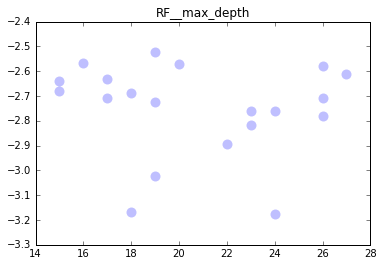

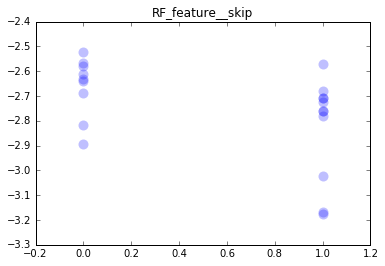

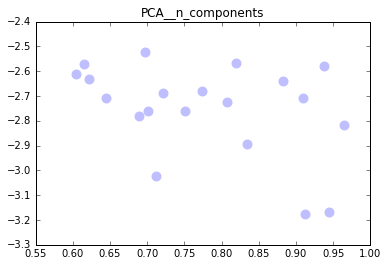

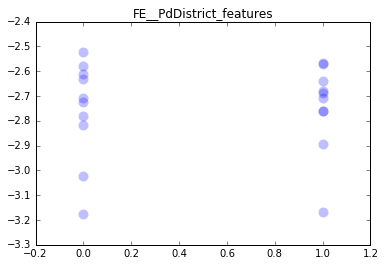

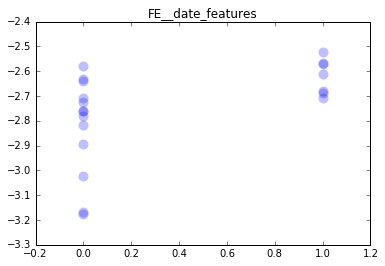

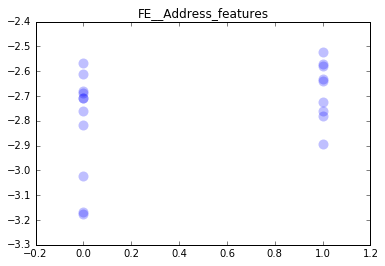

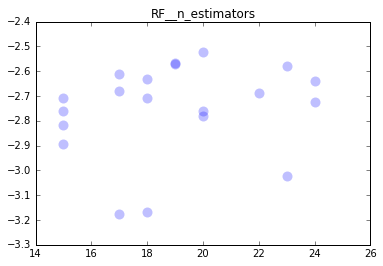

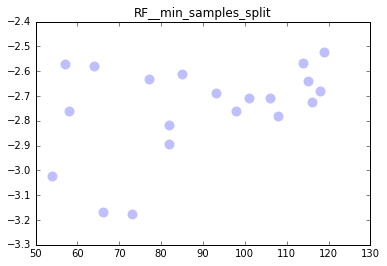

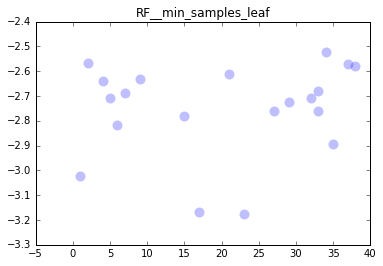

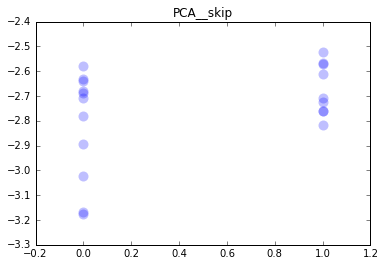

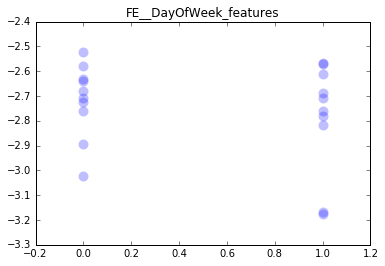

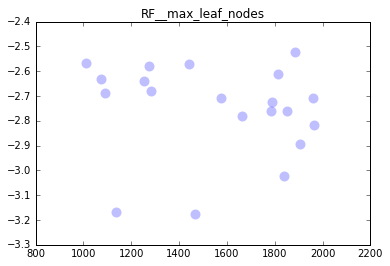

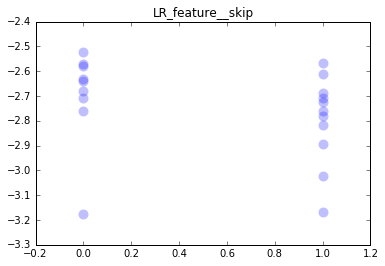

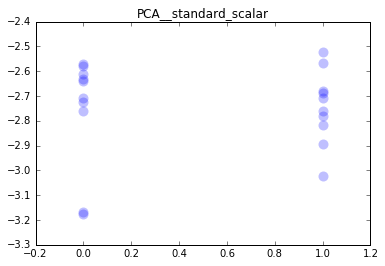

Wall time: 3min 31s


In [478]:
%%time

# This seed is required for each gridsearch to be identical
np.random.seed(42)

# Define the ML pipe
pipe = Pipeline([("FE", FeatureEngineering()), 
                 ("just_numerics", JustNumerics()), 
                 ("PCA", PCATransform()), 
                 ("LR_feature", ModelBasedFeatures(LogisticRegression(), feature_name="LR_feature")),
                 ("RF_feature", ModelBasedFeatures(model=RandomForestClassifier(), feature_name="RF_feature")),
                 ("RF", RandomForestClassifier(n_jobs=-1))])

PCA_factor = .6

params = {"FE__date_features": sp_randint(0, 2),
          "FE__DayOfWeek_features": sp_randint(0, 2),
          "FE__PdDistrict_features": sp_randint(0, 2),
          "FE__Address_features": sp_randint(0, 2),
          "PCA__n_components": sp_uniform(PCA_factor, 1-PCA_factor),
          "PCA__skip": sp_randint(0, 2),
          "PCA__standard_scalar": sp_randint(0, 2),
          "RF_feature__skip": sp_randint(0, 2),
          "LR_feature__skip": sp_randint(0, 2),
          "RF__n_estimators": sp_randint(15, 25),
          "RF__max_depth": sp_randint(15, 30),
          "RF__min_samples_split": sp_randint(50, 120),
          "RF__min_samples_leaf": sp_randint(1, 40),
          "RF__max_leaf_nodes": sp_randint(1000, 2000),
         }

fit_params = {"RF_feature__n_estimators": sp_randint(5, 10),
              "RF_feature__max_depth": sp_randint(5, 10),
              "LR_feature__C": sp_expon(0, 100)}
 
gridsearch = RandomizedSearchCV(pipe, params, fit_params=fit_params, n_iter=20, scoring="log_loss", cv=2)
gridsearch.fit(X, y)

print("Best score:", gridsearch.best_score_, "\n")
print("")

gridsearch_parameter_results(gridsearch)

In [472]:
%%time
# Read in data to predict and make predictions
X_predict = pd.read_csv("../../data/test.csv")

Wall time: 2.26 s


In [473]:
final_predictions = gridsearch.predict_proba(X_predict)

In [474]:
%%time
# Export predictions to file to be submitted to Kaggle
make_Kaggle_file(final_predictions, labels.classes_, decimal_limit=4)

Finished writing file:  sf_crime_test_predictions_20160403-161012.csv
Wall time: 1min 10s
